# Breakout: Individual Project Code

## Google Drive Integration

Mount Google Drive.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Setup

Import modules.

In [3]:
import gym
import numpy as np
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import cv2

Set device.

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device: ', device)

device:  cpu


Set environment.

In [5]:
env = gym.make('Breakout-v0')

Set seed for reproducible environment and action spaces

In [6]:
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

[742]

## Environment preview

In [7]:
def show_image(image, greyscale=False):
    """Displays image without grid lines."""
    if greyscale:
        plt.imshow(image, cmap=plt.get_cmap('gray'))    
    else:
        plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

Show the initial state and print its shape.

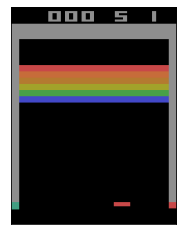

obervation space:  Box(210, 160, 3)
action space:  Discrete(4)
no. actions:  4


In [8]:
observation = env.reset()

show_image(observation)
plt.show()

print('obervation space: ', env.observation_space)
print('action space: ', env.action_space)
print('no. actions: ', env.action_space.n)

Take a random action, then make an observation.

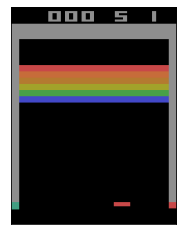

action: 0
reward: 0.0
done False
info {'ale.lives': 5}


In [9]:
random_action = env.action_space.sample()

next_observation, reward, done, info = env.step(random_action)

show_image(next_observation)
plt.show()

print('action:', random_action)
print('reward:', reward)
print('done', done)
print('info', info)

## Frame pre-processing

In [10]:
obs = env.reset()

### Greyscale

shape before:  (210, 160, 3)
shape after:   (210, 160)


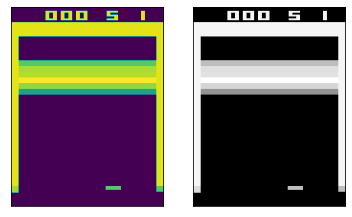

In [11]:
print("shape before: ", obs.shape)
gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
print("shape after:  ", gray_obs.shape)

plt.subplot(1, 2, 1)
show_image(gray_obs)
plt.subplot(1, 2, 2)
show_image(gray_obs, greyscale=True)
plt.show()

### Crop

shape before:  (210, 160)
shape after:   (160, 160)


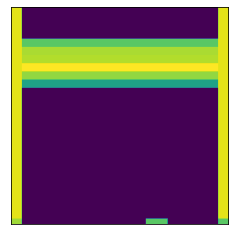

In [12]:
print('shape before: ', gray_obs.shape)
cropped_obs = gray_obs[33:193]
print('shape after:  ', cropped_obs.shape)

show_image(cropped_obs)

### Resize

shape before:  (160, 160)
shape after transformation:   (84, 84)


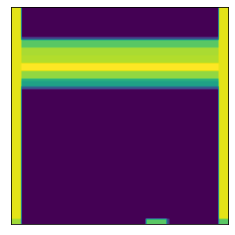

In [13]:
print("shape before: ", cropped_obs.shape)
resized_obs = cv2.resize(cropped_obs, (84, 84))
print("shape after transformation:  ", resized_obs.shape)

show_image(resized_obs)

### Rotate

In [14]:
if env.unwrapped.spec.id == 'Pong-v0':
    rotated_obs = cv2.rotate(resized_obs, cv2.cv2.ROTATE_90_CLOCKWISE)

    show_image(rotated_obs)

### Pre-processing function

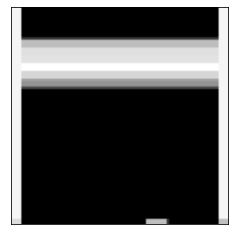

In [15]:
def preprocess(obs):
  gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
  cropped_obs = gray_obs[33:193]
  resized_obs = cv2.resize(cropped_obs, (84, 84))
  if env.unwrapped.spec.id == 'Pong-v0':
    return cv2.rotate(resized_obs, cv2.cv2.ROTATE_90_CLOCKWISE)
  else:
    return resized_obs

show_image(preprocess(env.reset()), greyscale=True)

View pre-processed next state, having taken a random action. 

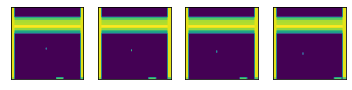

In [16]:
for i in range(4):
    rand_act = env.action_space.sample()
    obs = env.step(rand_act)[0]
    
    plt.subplot(1, 4, i+1)
    show_image(preprocess(obs))
plt.show()

## State

In [17]:
def show_state(state):
    for i, frame in enumerate(state):
        plt.subplot(1, len(state), i+1)
        plt.imshow(frame, cmap=plt.get_cmap('gray'))
        plt.xticks([])
        plt.yticks([])

In [18]:
state = torch.zeros(4, 84, 84)

current state:


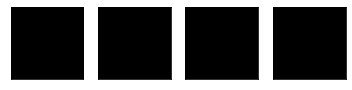

next state:


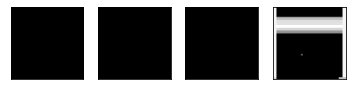

In [19]:
print('current state:')
show_state(state)
plt.show()

action = env.action_space.sample()
next_obs = preprocess(env.step(action)[0])

state = torch.roll(state, shifts=-1, dims=0)
state[-1] = torch.tensor(next_obs).unsqueeze(0)

print('next state:')
show_state(state)
plt.show()

## Model definition

### Define CNN layer.

In [20]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
    nn.ReLU()
    )

cnn.to(device)

Sequential(
  (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
)

Feed state buffer stack through CNN layer.

In [21]:
cnn_out = cnn(state.unsqueeze(0))
print('shape of CNN output: ', cnn_out.shape)

shape of CNN output:  torch.Size([1, 64, 7, 7])


Flatten CNN layer output, and print.

In [22]:
fc_input_dim = cnn_out.flatten().shape[0]
print('fully connecetd layer input size: ', fc_input_dim)

fully connecetd layer input size:  3136


### Define fully-connected (fc) policy layer.

In [23]:
fc_pi = nn.Sequential(
    nn.Linear(fc_input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, env.action_space.n)
    )

fc_pi.to(device)

Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=4, bias=True)
)

Reshape CNN layer output, then feed through fc layer.

In [24]:
shape_before = cnn_out.shape
print('shape before reshape: ', shape_before)
fc_input = cnn_out.reshape(-1, fc_input_dim)
print('shape after reshape:  ', fc_input.shape)

shape before reshape:  torch.Size([1, 64, 7, 7])
shape after reshape:   torch.Size([1, 3136])


View fc policy layer output.

In [25]:
fc_output = fc_pi(fc_input)
fc_output

tensor([[-0.1238, -0.1484,  0.3725,  0.0406]], grad_fn=<AddmmBackward>)

View fc layer output shape to obtain softmax dimension.

In [26]:
print(fc_output.shape)

torch.Size([1, 4])


We want the sum of action probabilities to equal 1. The porbabilities come from the values on the last axis (axis 1).

In [27]:
softmax_dim = 1

Obtain action probabilities from values.

In [28]:
prob = F.softmax(fc_output, dim=softmax_dim)
prob

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)

Turn action probabilities into a categorical distribution.

> 'A categorical distribution is a discrete probability distribution that describes the possible results of a random variable that can take on one of K possible categories, with the probability of each category separately specified' &mdash; Wikipedia

In [29]:
m = Categorical(prob)
m

Categorical(probs: torch.Size([1, 4]))

Sample an action from the categorical distribution.

In [30]:
a = m.sample().item() # .item() converts it from tensor to int
a

0

### Define fully connected (fc) value layer.

In [31]:
fc_v = nn.Sequential(
    nn.Linear(fc_input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
    )

fc_v.to(device)

Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1, bias=True)
)

View fc value layer output.

In [32]:
fc_out = fc_v(fc_input)
fc_out

tensor([[0.4275]], grad_fn=<AddmmBackward>)

### Define functions

Define a function to pass a state buffer stack through the network and obtain action probabilities.

In [33]:
def pi(x):
  x_t = x.to(device)
  cnn_out = cnn(x_t)
  fc_in = cnn_out.reshape(-1, fc_input_dim)
  fc_out = fc_pi(fc_in)
  prob = F.softmax(fc_out, dim=softmax_dim)
  return prob

Check `pi` output.

In [34]:
pi(state.unsqueeze(0))

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)

In [35]:
def v(x):
  x_t = x.to(device)
  cnn_out = cnn(x_t)
  fc_in = cnn_out.reshape(-1, fc_input_dim)
  v = fc_v(fc_in)
  return v

Check `v` output.

In [36]:
v(state.unsqueeze(0))

tensor([[0.4275]], grad_fn=<AddmmBackward>)

## Checks

Get probability as float from tensor.

In [37]:
prob = pi(state.unsqueeze(0))
m = Categorical(prob)
a = m.sample().item()
print(prob)
print('action: ', a)
print('action probability: ', prob.cpu().detach().numpy()[0][a])

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)
action:  2
action probability:  0.34243265


## Proximal Policy Optimisation (PPO)

In [38]:
# hyperparameters
learning_rate = 0.5e-4
gamma         = 0.99
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 1

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        self.loss_data = deque(maxlen=100)
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
            )
        
        self.fc_pi = nn.Sequential(
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n)
            )
        
        self.fc_v = nn.Sequential(
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
            )
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim=1):
        cnn_out = self.cnn(x).reshape(-1, fc_input_dim)
        prob = F.softmax(self.fc_pi(cnn_out), dim=softmax_dim)
        return prob
    
    def v(self, x):
        cnn_out = self.cnn(x).reshape(-1, fc_input_dim)
        v = self.fc_v(cnn_out)
        return v

    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float, device=device), torch.tensor(a_lst, device=device), \
                                          torch.tensor(r_lst, device=device), torch.tensor(s_prime_lst, dtype=torch.float, device=device), \
                                          torch.tensor(done_lst, dtype=torch.float, device=device), torch.tensor(prob_a_lst, device=device)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.cpu().detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float, device=device)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())
            self.loss_data.append(torch.mean(loss).detach().numpy())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()


## Training loop and results

In [39]:
from datetime import datetime
import os
from collections import deque
import time
from random import randint

env_name = 'Breakout-v0'
dir_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '_' + env_name
video_dir = dir_name + '/video'

os.mkdir(dir_name)

env = gym.make(env_name)
env = gym.wrappers.Monitor(env, video_dir, video_callable=lambda episode_id: (episode_id%video_every)==0,force=True)

# seed
seed = 742 #randint(1, 999) #742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)
print('seed:', seed)

# hyperparameters
T_horizon     = 32
video_every   = 1
print_every   = 1
number_of_games = 10

figure_file = dir_name + '/figure.png'
scores_file = dir_name + '/scores.txt'

# logs
scores = deque(maxlen=100)
episode_lengths = deque(maxlen=100)
learn_iters = 0
avg_score = 0
n_steps = 0

model = PPO().to(device)
model.load_state_dict(torch.load('./adam05e-5_T032_K1_seed742 (1of2)/ep=100_avg=0.96.pth'))

for n_episode in range(number_of_games+1):

    episode_length = 0
    score = 0.0
    done = False

    obs = preprocess(env.reset())
    state = np.stack((obs, obs, obs, obs), axis=0)
    
    episode_start_time = time.time()
    while not done: 
        for t in range(T_horizon):
            prob = model.pi(torch.from_numpy(state).float().unsqueeze(0))
            m = Categorical(prob)
            a = m.sample().item()

            # if t == 0:
            #     print(prob)
            #     show_state(state)
            #     plt.show()

            reward = 0
            for _ in range(4):
                next_obs, r, done, info = env.step(a)
                reward += r

                if done:
                    break
            next_state = np.roll(state, shift=-1, axis=0)
            next_state[-1] = preprocess(next_obs) 
            model.put_data((state, a, reward, next_state, prob.cpu().detach().numpy()[0][a], done))
            state = next_state

            n_steps += 1
            episode_length += 1
            score += reward

            if done:
                break
        model.train_net()
        
        episode_time_taken = time.time() - episode_start_time
        learn_iters += 1
    scores.append(score)
    episode_lengths.append(episode_length)
    avg_score = np.array(scores).mean()

    if n_episode%print_every == 0:
        print("episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}, mean_loss: {:.2f}, std_loss: {:.2f}, ep_len: {}, mean_ep_len: {:.1f}, tot_t_steps: {}, tot_learn_steps: {}, ep_t_taken: {:.1f}".format(
                n_episode, score, avg_score, np.array(scores).std(), np.array(model.loss_data).mean(), np.array(model.loss_data).std(), episode_length, np.array(episode_lengths).mean(), 
                n_steps, learn_iters, episode_time_taken))

    if n_episode%video_every == 0:
        pth = dir_name + '/' + 'ep=' + str(n_episode) + '_avg=' + '%.2f' % avg_score + '.pth'
        torch.save(model.state_dict(), pth)

env.close()

seed: 742
episode: 0, score: 2.0, mean_score: 2.00, std_score: 0.00, mean_loss: 0.06, std_loss: 0.36, ep_len: 75, mean_ep_len: 75.0, tot_t_steps: 75, tot_learn_steps: 3, ep_t_taken: 1.9
episode: 1, score: 1.0, mean_score: 1.50, std_score: 0.50, mean_loss: 0.16, std_loss: 0.35, ep_len: 69, mean_ep_len: 72.0, tot_t_steps: 144, tot_learn_steps: 6, ep_t_taken: 1.7
episode: 2, score: 2.0, mean_score: 1.67, std_score: 0.47, mean_loss: 0.06, std_loss: 0.33, ep_len: 86, mean_ep_len: 76.7, tot_t_steps: 230, tot_learn_steps: 9, ep_t_taken: 1.8
episode: 3, score: 0.0, mean_score: 1.25, std_score: 0.83, mean_loss: 0.06, std_loss: 0.31, ep_len: 60, mean_ep_len: 72.5, tot_t_steps: 290, tot_learn_steps: 11, ep_t_taken: 1.3
episode: 4, score: 1.0, mean_score: 1.20, std_score: 0.75, mean_loss: 0.04, std_loss: 0.29, ep_len: 60, mean_ep_len: 70.0, tot_t_steps: 350, tot_learn_steps: 13, ep_t_taken: 1.1
episode: 5, score: 2.0, mean_score: 1.33, std_score: 0.75, mean_loss: -0.01, std_loss: 0.28, ep_len: 72,

In [40]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']